<a href="https://colab.research.google.com/github/Ignacio-Ibarra/NLP-Disasters/blob/intento_4/intento_5/model/LSTM_with_Data_Augmentation_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Libraries

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Reading CSV files

In [3]:
complete = pd.read_csv('https://raw.githubusercontent.com/Ignacio-Ibarra/NLP-Disasters/intento_4/intento_4/csv/complete_cleaned.csv')

In [4]:
complete.drop(columns='Unnamed: 0', inplace=True)

In [5]:
test = complete[complete.istrain == 0].reset_index(drop=True)
test.drop(columns='target',inplace=True)
x_test = test.drop(columns='istrain')

In [6]:
id_test=x_test.id

In [9]:
train_df_augmented = pd.read_csv('/content/gdrive/My Drive/Organizacion_de_datos/train_df_combined.csv')
x_train = train_df_augmented['text']
len(x_train)

11552

In [11]:
y_train = train_df_augmented['target']

In [12]:
x_train = x_train.apply(lambda x: " ".join([str(i) for i in str(x).split()]))
x_test = x_test['text'].apply(lambda x: " ".join([str(i) for i in str(x).split()]))

# Tokenizer

## Instantiating the Tokenizer

In [13]:
uniques = []
for i in x_train.values:
  words = str(i).split()
  for word in words:
    if word not in uniques:
      uniques.append(word)
len(uniques)

38451

In [14]:
#Top word is the quantity of differents words that our word_index will have. 
top_word = 40000

In [15]:
#Here we instantiate the tokenizer
tokenizer = Tokenizer(num_words=top_word)

#Here we make the fit we three features that are strings
tokenizer.fit_on_texts(x_train)

## Text to sequences of word_indexes

Converting the text into a sequence of integers, all of them are indexes of the tokenizer.word_index

In [16]:
#Training set to sequence
x_train = tokenizer.texts_to_sequences(x_train)

#Test set to sequence
x_test = tokenizer.texts_to_sequences(x_test)



## Padding sequence

We add zeros into each sequence unitl complete a maximum of lenght

In [17]:
#MAXLEN for text, location and keyword
max_words = max([len(x) for x in x_train]) + 1


print("top_word: ", str(top_word))
print("max_words: ", str(max_words))


top_word:  40000
max_words:  48


In [19]:
#Padding


x_train = sequence.pad_sequences(x_train, maxlen=max_words,padding='post')


x_test = sequence.pad_sequences(x_test, maxlen=max_words, padding='post')

print("X_train_txt.shape: ", x_train.shape)


X_train_txt.shape:  (11552, 48)


# y_train to_categorical

In [20]:
# One-hot category
from keras.utils import to_categorical
y_train = to_categorical(y_train)
print("y_train.shape: ", y_train.shape)

y_train.shape:  (11552, 2)


## Loading word embedding file

---



In [21]:
#Installing PyDrive
!pip install PyDrive

In [22]:
#Importing modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [23]:
#Authenticating and creating the PyDrive client (ACA TENES QUE ENTRAR AL LINK, ENTRAR CON TU CUENTA DE GMAIL, TE VA A DAR UN ID UNA VEZ QUE LE DES 'ALLOW' 
#Y LUEGO TENES QUE COPIAR EL ID EN EL CAMPO QUE TE VA A GENERAR EN ESTA CELDA)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [24]:
#Getting the file
downloaded2 = drive.CreateFile({'id':"1LA2yR5TRNPQu2btbbFVVHMqcHsj3yCuS"})   # replace the id with id of file you want to access
downloaded2.GetContentFile('glove.twitter.27B.200d.txt')                             # replace the filename of file you want to access   

In [25]:
embeddings_dictionary = dict()
glove_file = open('glove.twitter.27B.200d.txt', encoding="utf8")

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [27]:
embedding_dim = 200
embedding_matrix = zeros((top_word, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# LSTM Model

In [28]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from keras.layers import Bidirectional,  Reshape, Flatten, GRU
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Model 1 - 'Text' Augmented with GPT-2

In [29]:
# Defining the LSTM model 1

input1 = Input(shape=(max_words,))
embedding_layer1 = Embedding(top_word, embedding_dim, weights=[embedding_matrix], input_length=max_words, trainable=False)(input1)
dropout1 = Dropout(0.2)(embedding_layer1)
lstm1_1 = LSTM(128,return_sequences = True)(dropout1)
lstm1_2 = LSTM(128,return_sequences = True)(lstm1_1)
lstm1_2a = LSTM(128,return_sequences = True)(lstm1_2)
lstm1_3 = LSTM(128)(lstm1_2a)

# input2 = Input(shape=(max_words_key,))
# embedding_layer2 = Embedding(top_word, embedding_dim, weights=[embedding_matrix], input_length=max_words_key, trainable=False)(input2)
# dropout2 = Dropout(0.2)(embedding_layer2)
# lstm2_1 = LSTM(64,return_sequences = True)(dropout2)
# lstm2_2 = LSTM(64,return_sequences = True)(lstm2_1)
# lstm2_3 = LSTM(64)(lstm2_2)

# input3 = Input(shape=(max_words_loc,))
# embedding_layer3 = Embedding(top_word, embedding_dim, weights=[embedding_matrix], input_length=max_words_loc, trainable=False)(input3)
# dropout3 = Dropout(0.2)(embedding_layer3)
# lstm3_1 = LSTM(32,return_sequences = True)(dropout3)
# lstm3_2 = LSTM(32,return_sequences = True)(lstm3_1)
# lstm3_3 = LSTM(32)(lstm3_2)

# mlp = create_mlp(continuous_shape,log_regress=False)

# merge = concatenate([lstm1_3, lstm2_3,lstm3_3,mlp.output])

dropout = Dropout(0.8)(lstm1_3)
dense1 = Dense(256, activation='relu')(dropout)
dense2 = Dense(128, activation='relu')(dense1)
output = Dense(2, activation='softmax')(dense2)
model1 = Model(inputs=input1, outputs=output)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 48, 200)           8000000   
_________________________________________________________________
dropout (Dropout)            (None, 48, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 128)           168448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)              

### Optimizer

In [30]:
from keras.optimizers import Adam

optimizer1 = Adam(lr = .0001, beta_1 = .9, beta_2 = .999, epsilon = 1e-10, decay = .0, amsgrad = False)
model1.compile(loss="binary_crossentropy", optimizer=optimizer1,
              metrics=["accuracy"])


### Training

In [31]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience = 4)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, 
                                           factor = 0.5, min_lr = 1e-8, cooldown=1)

prueba  = model1.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=16, verbose=2, callbacks=[es, learning_rate_reduction])

Epoch 1/20
578/578 - 117s - loss: 0.5567 - accuracy: 0.7243 - val_loss: 0.5825 - val_accuracy: 0.7118
Epoch 2/20
578/578 - 112s - loss: 0.4958 - accuracy: 0.7788 - val_loss: 0.5748 - val_accuracy: 0.7109
Epoch 3/20
578/578 - 116s - loss: 0.4832 - accuracy: 0.7818 - val_loss: 0.5759 - val_accuracy: 0.7213
Epoch 4/20
578/578 - 116s - loss: 0.4746 - accuracy: 0.7844 - val_loss: 0.5867 - val_accuracy: 0.7084
Epoch 5/20

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
578/578 - 117s - loss: 0.4697 - accuracy: 0.7905 - val_loss: 0.5694 - val_accuracy: 0.7157
Epoch 6/20
578/578 - 118s - loss: 0.4572 - accuracy: 0.7928 - val_loss: 0.5754 - val_accuracy: 0.7187
Epoch 7/20

Epoch 00007: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
578/578 - 117s - loss: 0.4522 - accuracy: 0.7959 - val_loss: 0.5707 - val_accuracy: 0.7174
Epoch 8/20
578/578 - 114s - loss: 0.4426 - accuracy: 0.7974 - val_loss: 0.5773 - val_accuracy: 0.7135
Epoch 9/20

Epoch 0000

### Plotting results

In [32]:
#Function to plot loss + accuracy in training and validation sets

def result_eva (loss,val_loss,acc,val_acc):
       
    epochs = range(1,len(loss)+1)
    plt.plot(epochs, loss,'b-o', label ='Training Loss')
    plt.plot(epochs, val_loss,'r-o', label ='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, "b-o", label="Training Acc")
    plt.plot(epochs, val_acc, "r-o", label="Validation Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

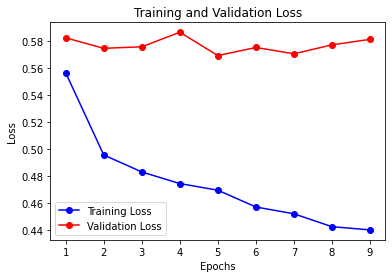

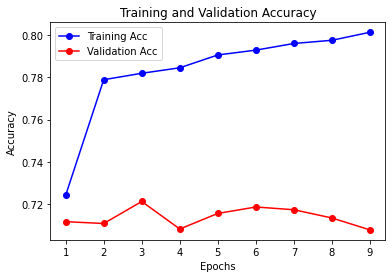

In [33]:
result_eva(prueba.history['loss'], prueba.history['val_loss'], prueba.history['accuracy'], prueba.history['val_accuracy'])

### Predicting

In [ ]:
#Predicting test data

y_pred = model1.predict([x_test_txt,x_test_key,x_test_loc,x_test_continuous], batch_size=16, verbose=2)

204/204 - 13s


In [ ]:
y_pred = np.argmax(y_pred,axis=1)

### Creating df for make the submission

In [ ]:
df = pd.DataFrame()
df['id'] = [int(x) for x in id_test.values]
df['target'] = y_pred


In [ ]:
from google.colab import files
df.to_csv('29.submit.csv', index=False)
files.download('29.submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 2 - LSTM+CNN with Data Augmentation - in Kaggle  0.80845



In [35]:
input1 = Input(shape=(max_words,))
embedding_layer1 = Embedding(top_word, embedding_dim, weights=[embedding_matrix], input_length=max_words, trainable=False)(input1)
lstm1_1 = Bidirectional(LSTM(100, return_sequences=True,dropout = 0.2))(embedding_layer1)
lstm1_1a = Bidirectional(LSTM(100, return_sequences=True,dropout = 0.2))(lstm1_1)
lstm1_1b = Bidirectional(LSTM(100, return_sequences=True,dropout = 0.2))(lstm1_1a)
res = Reshape((-1, x_train.shape[1], 100))(lstm1_1b)
conv1 = Conv2D(100, (3,3), padding='same',activation="relu")(res)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
flat1 = Flatten()(pool1)

# input2 = Input(shape=(max_words_key,))
# embedding_layer2 = Embedding(top_word, embedding_dim, weights=[embedding_matrix], input_length=max_words_key, trainable=False)(input2)
# lstm2_1 = Bidirectional(LSTM(200, return_sequences=True,dropout = 0.2))(embedding_layer2)
# lstm2_1a = Bidirectional(LSTM(200, return_sequences=True,dropout = 0.2))(lstm2_1)
# lstm2_1b = Bidirectional(LSTM(200, return_sequences=True,dropout = 0.2))(lstm2_1a)
# res2 = Reshape((-1, x_train_key.shape[1], 200))(lstm2_1b)
# conv2 = Conv2D(200, (3,3), padding='same',activation="relu")(res2)
# pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
# flat2 = Flatten()(pool2)

# input3 = Input(shape=(max_words_loc,))
# embedding_layer3 = Embedding(top_word, embedding_dim, weights=[embedding_matrix], input_length=max_words_loc, trainable=False)(input3)
# lstm3_1 = Bidirectional(LSTM(200, return_sequences=True,dropout = 0.2))(embedding_layer3)
# lstm3_1a = Bidirectional(LSTM(200, return_sequences=True,dropout = 0.2))(lstm3_1)
# lstm3_1b = Bidirectional(LSTM(200, return_sequences=True,dropout = 0.2))(lstm3_1a)
# res3 = Reshape((-1, x_train_loc.shape[1], 200))(lstm3_1b)
# conv3 = Conv2D(200, (3,3), padding='same',activation="relu")(res3)
# pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
# flat3 = Flatten()(pool3)

# mlp = create_mlp(continuous_shape,log_regress=False)

# merge = concatenate([flat1, flat2, flat3, mlp.output])

dropout = Dropout(0.4)(flat1)
dense1 = Dense(256, activation='relu')(dropout)
dense2 = Dense(128, activation='relu')(dense1)
output = Dense(2, activation='softmax')(dense2)
model2 = Model(inputs=input1, outputs=output)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 48, 200)           8000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 48, 200)           240800    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 48, 200)           240800    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 48, 200)           240800    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 48, 100)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 48, 100)       

In [36]:
from keras.optimizers import Adam

optimizer2 = Adam(lr = .0001, beta_1 = .9, beta_2 = .999, epsilon = 1e-10, decay = .0, amsgrad = False)

In [37]:
model2.compile(loss="binary_crossentropy", optimizer=optimizer2,
              metrics=["accuracy"])

In [43]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience = 4)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, 
                                           factor = 0.5, min_lr = 1e-8, cooldown=1)

prueba2 = model2.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=18, verbose=2, callbacks=[es, learning_rate_reduction])

Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 00007: early stopping


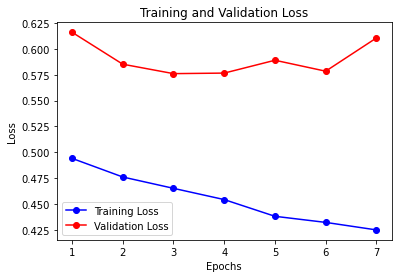

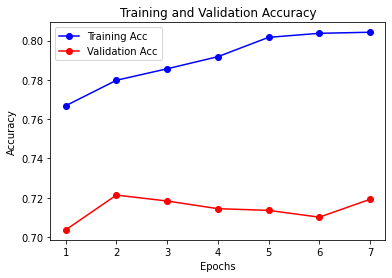

In [46]:
result_eva(prueba2.history['loss'], prueba2.history['val_loss'], prueba2.history['accuracy'], prueba2.history['val_accuracy'])

In [51]:
#Predicting test data

y_pred = model2.predict(x_test, batch_size=16, verbose=2)

204/204 - 13s


In [52]:
y_pred = np.argmax(y_pred,axis=1)

In [53]:
df = pd.DataFrame()
df['id'] = [int(x) for x in id_test.values]
df['target'] = y_pred
df.to_csv('33.submit.csv', index=False)

In [54]:
from google.colab import files
files.download('33.submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>